Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip



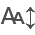

In [4]:
# Factor Analysis about the results obtainer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
!pip install itables

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)
from itables import show



In [5]:
# Load the data 

columns = ['Name', 'train_datasets', 'test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016']
columns += ['test/test_calibration_iam', 'test/test_calibration_washington', 'test/test_calibration_bentham', 'test/test_calibration_rimes', 'test/test_calibration_saint_gall', 'test/test_calibration_rodrigo', 'test/test_calibration_icfhr_2016']

# pd_all
# pd_all = pd.read_csv('../results/ctc_results.csv') # TODO: Change to the correct path
pd_all = pd.read_csv('../results/results_all_final.csv') # TODO: Change to the correct path
pd_all['train_datasets'] = pd_all['train_datasets'].apply(lambda x: x.removeprefix('[').removesuffix(']').split(',')[0])

# Apply the following dictionary to Name columns creating a new column called architecture removing before _src_ in name
pd_all['architecture'] = pd_all['Name'].apply(lambda x: x.split('_src_')[0])

# Drop if any of the columns contains a NaN value
# print(pd_all.isna().sum())
# pd_all = pd_all.dropna()
print(pd_all.columns)
pd_all = pd_all[['Name'] + ['architecture'] + columns[1:]]

# Melt the table to have each test/test_cer_{dataset} in a single column
pd_all = pd.melt(pd_all, id_vars=['Name', 'train_datasets', 'architecture'], value_vars=['test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016'], var_name='test_dataset', value_name='CER')

# Remove test/test_cer_ from test_dataset
pd_all['test_dataset'] = pd_all['test_dataset'].apply(lambda x: x.removeprefix('test/test_cer_'))
pd_all['train_datasets'] = pd_all['train_datasets'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)

# Create a new column called scenario with ID if train_datasets == test_dataset and OOD if train_datasets != test_dataset
pd_all['scenario'] = pd_all.apply(lambda x: 'ID' if x['train_datasets'] == x['test_dataset'] else 'OOD', axis=1)
pd_all['CER'] = pd_all['CER'] * 100

# Cap the CER value to 100
pd_all['CER'] = pd_all['CER'].apply(lambda x: min(x, 100))

# Drop  if scenario is ID and CER > 40
# pd_all = pd_all[~((pd_all['scenario'] == 'ID') & (pd_all['CER'] > 40))]


Index(['Name', 'ID', 'State', 'Created', 'Runtime', 'Tags', 'epoch',
       'train_config.batch_size', 'train_config.img_size', 'train_datasets',
       'val_datasets', 'test_datasets', 'vocab_size', 'best_in_domain_val_cer',
       'best_val_cer_iam', 'best_val_cer_washington',
       'best_val_cer_saint_gall', 'best_val_cer_rimes', 'best_val_cer_bentham',
       'best_val_cer_icfhr_2016', 'best_val_cer_rodrigo', 'test/test_cer_iam',
       'test/test_cer_washington', 'test/test_cer_saint_gall',
       'test/test_cer_rimes', 'test/test_cer_bentham',
       'test/test_cer_icfhr_2016', 'test/test_cer_rodrigo',
       'test/test_calibration_iam', 'test/test_calibration_washington',
       'test/test_calibration_rimes', 'test/test_calibration_bentham',
       'test/test_calibration_saint_gall', 'test/test_calibration_icfhr_2016',
       'test/test_calibration_rodrigo', 'architecture'],
      dtype='object')


In [6]:
show(pd_all)

## Results ID-OOD (no model selection)

In [7]:
# Remove _test from Name
pd_all['Name'] = pd_all['Name'].apply(lambda x: x.removesuffix('_test'))

In [8]:
# Remove if tgt or optim in Name
pd_all = pd_all[~pd_all['Name'].str.contains('tgt|optim')]
pd_all = pd_all.reset_index(drop=True)
display(pd_all)


Name train_datasets      architecture  \
0             crnn_michael_src_rimes_ID          rimes      crnn_michael   
1                crnn_puig_src_rimes_ID          rimes         crnn_puig   
2    transformer_kang_src_icfhr_2016_ID     icfhr_2016  transformer_kang   
3       transformer_kang_src_rodrigo_ID        rodrigo  transformer_kang   
4    transformer_kang_src_saint_gall_ID     saint_gall  transformer_kang   
..                                  ...            ...               ...   
387     light_barrere_src_washington_ID     washington     light_barrere   
388             crnn_michael_src_iam_ID            iam      crnn_michael   
389          v_light_barrere_src_iam_ID            iam   v_light_barrere   
390          light_barrere_src_rimes_ID          rimes     light_barrere   
391            light_barrere_src_iam_ID            iam     light_barrere   

    test_dataset         CER scenario  
0            iam   54.545456      OOD  
1            iam   35.427809      OOD  
2            iam   74.688333      OOD  
3            iam   81.706637      OOD  
4            iam  100.000000      OOD  
..           ...         ...      ...  
387   icfhr_2016  100.000000      OOD  
388   icfhr_2016   85.168678      OOD  
389   icfhr_2016   89.682770      OOD  
390   icfhr_2016   90.473449      OOD  
391   icfhr_2016   98.059231      OOD  

[392 rows x 6 columns]

In [9]:
pd_all_ood = pd_all[pd_all['scenario'] == 'OOD']
pd_all_ood['architecture'] = pd.Categorical(pd_all_ood['architecture'], ['crnn_puig', 'van_coquenet', 'cnn_san_arce', 'htr_vit', 'transformer_kang', 'crnn_michael', 'light_barrere', 'v_light_barrere'])
pd_all_ood = pd_all_ood.sort_values('architecture')
pd_all_ood = pd_all_ood.groupby(['test_dataset', 'architecture']).agg({'CER': 'min'}).reset_index()

# Sort architectures to be crnn_puig, van_coquenet, cnn_san_arce, htr_vit, transformer_kang, crnn_michael, light_barrere, v_light_barrere

# pd_all_ood
pd_all_ood_pivot = pd_all_ood.pivot_table(index='test_dataset', columns='architecture', values='CER', aggfunc='min').reset_index()
pd_all_ood_pivot['test_dataset'] = pd.Categorical(pd_all_ood_pivot['test_dataset'], ['iam', 'rimes', 'washington', 'bentham', 'saint_gall', 'rodrigo', 'icfhr_2016'])
pd_all_ood_pivot = pd_all_ood_pivot.sort_values('test_dataset')
pd_all_ood_pivot = pd_all_ood_pivot.reset_index(drop=True)
show(pd_all_ood_pivot)


/tmp/ipykernel_2726116/2739636582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_all_ood['architecture'] = pd.Categorical(pd_all_ood['architecture'], ['crnn_puig', 'van_coquenet', 'cnn_san_arce', 'htr_vit', 'transformer_kang', 'crnn_michael', 'light_barrere', 'v_light_barrere'])


/tmp/ipykernel_2726116/2470020742.py:39: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(data=pd_average_OOD, x='architecture', y='CER', hue='alignment', order=pd_average_OOD.sort_values('CER')['architecture'], errorbar='sd', capsize=0.1, errwidth=1.5, edgecolor='black', linewidth=1.5)


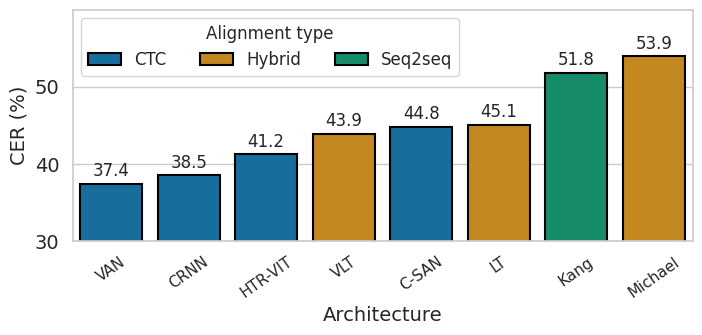

In [10]:
### Add a new table with only the mean results for each architecture per datasets
pd_average_OOD = pd_all_ood.groupby('architecture').agg({'CER': 'mean'}).reset_index()

# Add std to the table
pd_average_OOD['std'] = pd_all_ood.groupby('architecture').agg({'CER': 'std'}).reset_index()['CER']

# Add alignement type to the table as a dict: van_coquenet = 'CTC', crnn_puig = 'CTC', cnn_san_arce = 'CTC', htr_vit = 'CTC', transformer_kang = 'Seq2seq', crnn_michael = 'Hybrid', light_barrere = 'Hybrid', v_light_barrere = 'Hybrid'
alignement_dict = {'van_coquenet': 'CTC', 'crnn_puig': 'CTC', 'cnn_san_arce': 'CTC', 'htr_vit': 'CTC', 'transformer_kang': 'Seq2seq', 'crnn_michael': 'Hybrid', 'light_barrere': 'Hybrid', 'v_light_barrere': 'Hybrid'}
pd_average_OOD['alignment'] = pd_average_OOD['architecture'].map(alignement_dict)
pd_average_OOD = pd_average_OOD.sort_values('CER', ascending=True, ignore_index=False)

architectures_names =  dict({
  'v_light_barrere': 'VLT', 'van_coquenet': 'VAN', 'transformer_kang': 'Kang', 'cnn_san_arce': 'C-SAN',
  'light_barrere': 'LT', 'htr_vit': 'HTR-VIT', 'crnn_puig': 'CRNN', 'crnn_michael': 'Michael'
})

pd_average_OOD['architecture'] = pd_average_OOD['architecture'].map(architectures_names)

# Change Names

# Melt the table to have each test/test_cer_{dataset} in a single column
# pd_average_OOD = pd.melt(pd_average_OOD, id_vars=['architecture', 'alignment'], value_vars=['CER'], var_name='metric', value_name='CER')

show(pd_average_OOD)
show(pd_average_OOD['CER'])

# Make a barplot with the average CER sorted by this value for each architecture. Make the color of the bars according to the alignement type
# fig, ax = plt.subplots(figsize=(10, 6))
# Create vertical bar plot

# Make a beautiful barplot with seaborn for a paper
sns.set(style='whitegrid')
sns.set_palette('colorblind')

plt.figure(figsize=(8, 3))
plt.ylim(30, 60)

# Barplot and add std as error bars
sns.barplot(data=pd_average_OOD, x='architecture', y='CER', hue='alignment', order=pd_average_OOD.sort_values('CER')['architecture'], errorbar='sd', capsize=0.1, errwidth=1.5, edgecolor='black', linewidth=1.5)

plt.xticks(rotation=35, ha="center")
plt.yticks(np.arange(30, 56, 10), size=14)
plt.ylabel("CER (%)", size=14)
plt.xlabel("Architecture", size=14)

# Annotate the bars with the values
# Sorted CERs
sorted_cers = pd_average_OOD.sort_values('CER')['CER']
for i, cer in enumerate(sorted_cers):
    plt.text(i, cer + 0.5, f"{cer:.1f}", ha='center', va='bottom', size=12)

# plt.title("CER for HTR Architectures by Alignment Type")
plt.legend(title="Alignment type", loc='upper left', ncol=3, fontsize=12)
# Save as pdf
plt.savefig('../results/ranked_CER_OOD.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [11]:
pd_all_id = pd_all[pd_all['scenario'] == 'ID']
pd_all_id['architecture'] = pd.Categorical(pd_all_id['architecture'], ['crnn_puig', 'van_coquenet', 'cnn_san_arce', 'htr_vit', 'transformer_kang', 'crnn_michael', 'light_barrere', 'v_light_barrere'])
pd_all_id = pd_all_id.sort_values('architecture')

pd_all_id = pd_all_id.groupby(['test_dataset', 'architecture']).agg({'CER': 'min'}).reset_index()
pd_all_id_pivot = pd_all_id.pivot_table(index='test_dataset', columns='architecture', values='CER', aggfunc='min').reset_index()
# pd_all_id_pivot

# Sort test_datasets by ['iam', 'washington', 'bentham', 'rimes', 'saint_gall', 'rodrigo', 'icfhr_2016']
pd_all_id_pivot['test_dataset'] = pd.Categorical(pd_all_id_pivot['test_dataset'], ['iam', 'rimes', 'washington', 'bentham', 'saint_gall', 'rodrigo', 'icfhr_2016'])
pd_all_id_pivot = pd_all_id_pivot.sort_values('test_dataset')
pd_all_id_pivot = pd_all_id_pivot.reset_index(drop=True)
pd_all_id_pivot


/tmp/ipykernel_2726116/4161602290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_all_id['architecture'] = pd.Categorical(pd_all_id['architecture'], ['crnn_puig', 'van_coquenet', 'cnn_san_arce', 'htr_vit', 'transformer_kang', 'crnn_michael', 'light_barrere', 'v_light_barrere'])


architecture test_dataset  crnn_puig  van_coquenet  cnn_san_arce    htr_vit  \
0                     iam   6.371182      6.606574     14.971621  10.863325   
1                   rimes   3.742345      5.639034     11.972670   7.909957   
2              washington   8.208723      9.314642      8.971962  34.875390   
3                 bentham   4.665479      7.400153     10.045790   8.440600   
4              saint_gall   7.221132      7.812539      8.565465  17.116021   
5                 rodrigo   1.670893      2.318377      3.758865   3.891890   
6              icfhr_2016   5.213724      7.523481     17.026068  11.596703   

architecture  transformer_kang  crnn_michael  light_barrere  v_light_barrere  
0                     9.899610     12.929367       8.877662         8.921951  
1                     5.661715      8.167952       4.969948         5.145724  
2                    78.364486     53.847355      79.626167        25.249222  
3                     8.496566      8.544900       6.011193         6.112948  
4                    78.731704     76.897848      12.474219         9.211540  
5                     2.639180      3.805534       1.974791         2.187925  
6                     7.796627      9.478628       5.903776         6.004409

In [12]:
pd_all

Name train_datasets      architecture  \
0             crnn_michael_src_rimes_ID          rimes      crnn_michael   
1                crnn_puig_src_rimes_ID          rimes         crnn_puig   
2    transformer_kang_src_icfhr_2016_ID     icfhr_2016  transformer_kang   
3       transformer_kang_src_rodrigo_ID        rodrigo  transformer_kang   
4    transformer_kang_src_saint_gall_ID     saint_gall  transformer_kang   
..                                  ...            ...               ...   
387     light_barrere_src_washington_ID     washington     light_barrere   
388             crnn_michael_src_iam_ID            iam      crnn_michael   
389          v_light_barrere_src_iam_ID            iam   v_light_barrere   
390          light_barrere_src_rimes_ID          rimes     light_barrere   
391            light_barrere_src_iam_ID            iam     light_barrere   

    test_dataset         CER scenario  
0            iam   54.545456      OOD  
1            iam   35.427809      OOD  
2            iam   74.688333      OOD  
3            iam   81.706637      OOD  
4            iam  100.000000      OOD  
..           ...         ...      ...  
387   icfhr_2016  100.000000      OOD  
388   icfhr_2016   85.168678      OOD  
389   icfhr_2016   89.682770      OOD  
390   icfhr_2016   90.473449      OOD  
391   icfhr_2016   98.059231      OOD  

[392 rows x 6 columns]

### Get all matrix data for Factor Analysis

Final matrix should contain:
- Params. model
- Visual divergence source-target
- Lexical divergence source-target
- CER_{ID}
- CER_{OOD}
- ECE_{ID}

In [13]:
columns = ['Name', 'train_datasets', 'test/test_cer_iam', 'test/test_cer_washington', 'test/test_cer_bentham', 'test/test_cer_rimes', 'test/test_cer_saint_gall', 'test/test_cer_rodrigo', 'test/test_cer_icfhr_2016']
columns += ['test/test_calibration_iam', 'test/test_calibration_washington', 'test/test_calibration_bentham', 'test/test_calibration_rimes', 'test/test_calibration_saint_gall', 'test/test_calibration_rodrigo', 'test/test_calibration_icfhr_2016']

# pd_all
# pd_all = pd.read_csv('../results/ctc_results.csv') # TODO: Change to the correct path
pd_all = pd.read_csv('../results/results_all_final.csv') # TODO: Change to the correct path
pd_all['train_datasets'] = pd_all['train_datasets'].apply(lambda x: x.removeprefix('[').removesuffix(']').split(',')[0])

# Apply the following dictionary to Name columns creating a new column called architecture removing before _src_ in name
pd_all['architecture'] = pd_all['Name'].apply(lambda x: x.split('_src_')[0]) 


# # Drop if any of the columns contains a NaN value
# print(pd_all.isna().sum())
# pd_all = pd_all.dropna()
pd_all = pd_all[['Name'] + ['architecture'] + columns[1:]]
pd_all['train_datasets'] = pd_all['train_datasets'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)
pd_all = pd_all[~pd_all['Name'].str.contains('tgt|optim')]

show(pd_all)

# Iterate the rows to get CER (in-domain) and calibration (in-domain) for each row
pd_all_melted = pd.DataFrame(columns=['Name', 'train_datasets', 'architecture', 'test_dataset', 'CER_ID', 'CER_OOD', 'calibration_ID', 'calibration_OOD'])

for row, data in pd_all.iterrows():
    train_dataset = data['train_datasets']
    architecture = data['architecture']
    test_cers = dict({'iam': data['test/test_cer_iam'], 'washington': data['test/test_cer_washington'], 'bentham': data['test/test_cer_bentham'], 'rimes': data['test/test_cer_rimes'], 'saint_gall': data['test/test_cer_saint_gall'], 'rodrigo': data['test/test_cer_rodrigo'], 'icfhr_2016': data['test/test_cer_icfhr_2016']})
    test_calibrations = dict({
        'iam': data['test/test_calibration_iam'],'washington': data['test/test_calibration_washington'],'bentham': data['test/test_calibration_bentham'],'rimes': data['test/test_calibration_rimes'],'saint_gall': data['test/test_calibration_saint_gall'],'rodrigo': data['test/test_calibration_rodrigo'],'icfhr_2016': data['test/test_calibration_icfhr_2016']})
    
    cer_id = test_cers[train_dataset]
    calibration_id = test_calibrations[train_dataset]    
    
    for i, test_dataset in enumerate(['iam', 'washington', 'bentham', 'rimes', 'saint_gall', 'rodrigo', 'icfhr_2016']):
        # pd_all_melted = pd_all_melted.append({'Name': data['Name'],'train_datasets': train_dataset,'architecture': architecture,'test_dataset': test_dataset,'CER_ID': cer_id,'CER_OOD': test_cers[test_dataset],'calibration_ID': calibration_id,'calibration_OOD': test_calibrations[test_dataset]}, ignore_index=True)
        # Use concat instead of append
        if train_dataset != test_dataset:
        # if True:
            pd_all_melted = pd.concat([pd_all_melted, pd.DataFrame({'Name': data['Name'],'train_datasets': train_dataset,'architecture': architecture,'test_dataset': test_dataset,'CER_ID': cer_id,'CER_OOD': test_cers[test_dataset],'calibration_ID': calibration_id,'calibration_OOD': test_calibrations[test_dataset]}, index=[0])], ignore_index=True)
        # pd_all_melted = pd.concat([pd_all_melted, pd.DataFrame({'Name': data['Name'],'train_datasets': train_dataset,'architecture': architecture,'test_dataset': test_dataset,'CER_ID': cer_id,'CER_OOD': test_cers[test_dataset],'calibration_ID': calibration_id,'calibration_OOD': test_calibrations[test_dataset]}, index=[0])], ignore_index=True)
  

# # Melt the table to have each test/test_cer_{dataset} and test/test_calibration_{dataset} in two separate columns
# pd_all_cer = pd.melt(pd_all.copy(), id_vars=['Name', 'train_datasets', 'architecture'], value_vars=columns[2:9], var_name='test_dataset', value_name='CER')
# pd_all_cal = pd.melt(pd_all.copy(), id_vars=['Name', 'train_datasets', 'architecture'], value_vars=columns[9:], var_name='test_dataset', value_name='calibration')
# show(pd_all_cer)
# pd_all_melted = pd_all_cer

# pd_all_melted['calibration'] = pd_all_cal['calibration']

# pd_all_melted['test_dataset'] = pd_all_melted['test_dataset'].apply(lambda x: x.removeprefix('test/test_cer_'))
# pd_all_melted['train_datasets'] = pd_all_melted['train_datasets'].apply(lambda x: x.removeprefix('"').removesuffix('"')).astype(str)

# # # Create a new column called scenario with ID if train_datasets == test_dataset and OOD if train_datasets != test_dataset
# pd_all_melted['scenario'] = pd_all_melted.apply(lambda x: 'ID' if x['train_datasets'] == x['test_dataset'] else 'OOD', axis=1)
pd_all_melted['CER_ID'] = pd_all_melted['CER_ID'] * 100
pd_all_melted['CER_OOD'] = pd_all_melted['CER_OOD'] * 100

# # # Cap the CER value to 100
pd_all_melted['CER_ID'] = pd_all_melted['CER_ID'].apply(lambda x: min(x, 100))
pd_all_melted['CER_OOD'] = pd_all_melted['CER_OOD'].apply(lambda x: min(x, 100))

# Filter where column CER_ID > 30
pd_all_melted = pd_all_melted[~((pd_all_melted['CER_ID'] > 25))]
show(pd_all_melted)

# # pd_all_melted

In [14]:
# Add number of parameters according to the architecture
# pd_all_melted.architecture.unique
# dict(
#   'cnn_san_arce': 'C-SAN-Arce',
#   'crnn_puig': 'CRNN-Puig',
#   'van_coquenet': 'VAN-Coquenet'
# # )

# pd_all_grouped_avg_melted['n_parameters'] = pd_all_grouped_avg_melted['architecture'].apply(lambda x: 9.6 if x == 'Puigcerver' else 2.7 if x == 'VAN Coquenet' else 1.7 if x == 'C-SAN-Arce' else 53.5 if x == 'HTR-VIT' else 90 if x == 'Kang' else 62 if x == 'TrOCR' else 8 if x == 'Michael' else 7.7 if x == 'LT' else 5.6)

# Change architecture name according to dict
# pd_all_melted['architecture'] = pd_all_melted['architecture'].apply(lambda x: dict({'cnn_san_arce': 'C-SAN-Arce','crnn_puig': 'CRNN-Puig','van_coquenet': 'VAN-Coquenet'})[x])
print(pd_all_melted['architecture'].unique())
architectures_names =  dict({
  'v_light_barrere': 'VLT', 'van_coquenet': 'VAN', 'transformer_kang': 'Kang', 'cnn_san_arce': 'C-SAN',
  'light_barrere': 'LT', 'htr_vit': 'HTR-VIT', 'crnn_puig': 'CRNN', 'crnn_michael': 'Michael'
})

pd_all_melted['architecture'] = pd_all_melted['architecture'].map(architectures_names)
print(pd_all_melted['architecture'].unique())

# Set the number of parameters according to the architecture
# pd_all_melted['num_parameters'] = pd_all_melted['architecture'].apply(lambda x: dict({'C-SAN-Arce': 1.7, 'CRNN-Puig': 9.6, 'VAN-Coquenet': 2.7})[x])
pd_all_melted['num_parameters'] = pd_all_melted['architecture'].apply(lambda x: dict({'C-SAN': 1.7, 'CRNN': 9.6, 'VAN': 2.7, 'HTR-VIT': 53.5, 'Kang': 90, 'Michael': 8, 'LT': 7.7, 'VLT': 5.6})[x])
pd_all_melted


['crnn_michael' 'crnn_puig' 'transformer_kang' 'htr_vit' 'light_barrere'
 'van_coquenet' 'cnn_san_arce' 'v_light_barrere']
['Michael' 'CRNN' 'Kang' 'HTR-VIT' 'LT' 'VAN' 'C-SAN' 'VLT']


Name train_datasets architecture test_dataset  \
0    crnn_michael_src_rimes_ID_test          rimes      Michael          iam   
1    crnn_michael_src_rimes_ID_test          rimes      Michael   washington   
2    crnn_michael_src_rimes_ID_test          rimes      Michael      bentham   
3    crnn_michael_src_rimes_ID_test          rimes      Michael   saint_gall   
4    crnn_michael_src_rimes_ID_test          rimes      Michael      rodrigo   
..                              ...            ...          ...          ...   
331   light_barrere_src_iam_ID_test            iam           LT      bentham   
332   light_barrere_src_iam_ID_test            iam           LT        rimes   
333   light_barrere_src_iam_ID_test            iam           LT   saint_gall   
334   light_barrere_src_iam_ID_test            iam           LT      rodrigo   
335   light_barrere_src_iam_ID_test            iam           LT   icfhr_2016   

       CER_ID    CER_OOD  calibration_ID  calibration_OOD  num_parameters  
0    8.167952  54.545456        0.175784         0.209804             8.0  
1    8.167952  63.862926        0.175784         0.288631             8.0  
2    8.167952  70.223862        0.175784         0.391884             8.0  
3    8.167952  64.339137        0.175784         0.328618             8.0  
4    8.167952  66.828722        0.175784         0.306774             8.0  
..        ...        ...             ...              ...             ...  
331  8.877662  33.767489        0.072671         0.354966             7.7  
332  8.877662  30.789295        0.072671         0.253196             7.7  
333  8.877662  51.362967        0.072671         0.459570             7.7  
334  8.877662  48.408481        0.072671         0.430202             7.7  
335  8.877662  98.059231        0.072671         0.854684             7.7  

[294 rows x 9 columns]

In [15]:
# Read visual reconstruction errors and kl_divergence datasetes from csv
reconstruction_errors = pd.read_csv('../results/reconstruction_errors_matrix_raw.csv', index_col=0)
display(reconstruction_errors)

# Convert into a dict 
reconstruction_errors_dict = reconstruction_errors.to_dict(orient='index')
print(reconstruction_errors_dict)


iam     rimes  washington  saint_gall   bentham   rodrigo  \
iam         0.026565  0.022556    0.023349    0.046390  0.016161  0.047759   
rimes       0.062380  0.048819    0.045615    0.095761  0.033440  0.101431   
washington  0.048566  0.038332    0.033277    0.069951  0.027044  0.072814   
saint_gall  0.044775  0.036453    0.032815    0.057397  0.026826  0.066548   
bentham     0.030324  0.024930    0.024461    0.047959  0.014059  0.048842   
rodrigo     0.034388  0.028521    0.025693    0.039081  0.020311  0.032326   
icfhr_2016  0.033406  0.026935    0.026012    0.056439  0.018302  0.052667   

            icfhr_2016  
iam           0.027919  
rimes         0.080102  
washington    0.057726  
saint_gall    0.055447  
bentham       0.028399  
rodrigo       0.031402  
icfhr_2016    0.016488

{'iam': {'iam': 0.0265650003988736, 'rimes': 0.0225564826870634, 'washington': 0.0233494577432291, 'saint_gall': 0.0463898966386598, 'bentham': 0.0161611215779991, 'rodrigo': 0.0477590308765399, 'icfhr_2016': 0.0279191830790098}, 'rimes': {'iam': 0.0623799403460047, 'rimes': 0.0488185251513519, 'washington': 0.0456152132546609, 'saint_gall': 0.0957614284540925, 'bentham': 0.033439636194935, 'rodrigo': 0.1014307395954748, 'icfhr_2016': 0.0801019223436559}, 'washington': {'iam': 0.0485658968819583, 'rimes': 0.0383321324179001, 'washington': 0.0332773283475358, 'saint_gall': 0.069951428952752, 'bentham': 0.0270435622171769, 'rodrigo': 0.0728143485127288, 'icfhr_2016': 0.0577262028975914}, 'saint_gall': {'iam': 0.0447747254640336, 'rimes': 0.0364526709653006, 'washington': 0.0328148514649436, 'saint_gall': 0.0573969690281966, 'bentham': 0.0268256386047564, 'rodrigo': 0.0665481850734452, 'icfhr_2016': 0.0554474053365066}, 'bentham': {'iam': 0.0303242584139325, 'rimes': 0.0249298779745191, '

In [16]:
lexical_divergences_real = pd.read_csv('../results/kl_divergence_datasets.csv', index_col=0)
display(lexical_divergences_real)

# Convert into a dict
lexical_divergences_real_dict = lexical_divergences_real.to_dict(orient='index')
print(lexical_divergences_real_dict)

lexical_divergences = pd.read_csv('../results/kl_divergence_real_wit_ALL.csv', index_col=0)
display(lexical_divergences)

# Convert into a dict
lexical_divergences_dict = lexical_divergences.to_dict(orient='index')
print(lexical_divergences_dict)

iam  rimes  washington  saint_gall  bentham  rodrigo  icfhr_2016
iam         0.758  3.516       1.672       3.458    0.826    3.652       4.174
rimes       4.458  0.480       5.246       4.236    4.432    4.150       5.420
washington  2.948  5.036       2.048       5.096    2.670    5.082       5.354
saint_gall  4.238  4.136       5.232       1.486    4.190    3.698       5.484
bentham     1.476  3.970       2.100       3.896    0.752    4.206       4.688
rodrigo     4.194  4.010       4.854       3.994    4.220    0.368       5.012
icfhr_2016  4.746  5.568       5.448       5.640    4.924    5.390       1.202

{'iam': {'iam': 0.758, 'rimes': 3.516, 'washington': 1.672, 'saint_gall': 3.458, 'bentham': 0.826, 'rodrigo': 3.652, 'icfhr_2016': 4.174}, 'rimes': {'iam': 4.458, 'rimes': 0.48, 'washington': 5.246, 'saint_gall': 4.236, 'bentham': 4.432, 'rodrigo': 4.15, 'icfhr_2016': 5.42}, 'washington': {'iam': 2.9480000000000004, 'rimes': 5.036, 'washington': 2.048, 'saint_gall': 5.095999999999999, 'bentham': 2.6700000000000004, 'rodrigo': 5.082, 'icfhr_2016': 5.354}, 'saint_gall': {'iam': 4.238, 'rimes': 4.136, 'washington': 5.232, 'saint_gall': 1.486, 'bentham': 4.19, 'rodrigo': 3.698, 'icfhr_2016': 5.484}, 'bentham': {'iam': 1.4760000000000002, 'rimes': 3.97, 'washington': 2.1, 'saint_gall': 3.896, 'bentham': 0.752, 'rodrigo': 4.206, 'icfhr_2016': 4.688}, 'rodrigo': {'iam': 4.194, 'rimes': 4.01, 'washington': 4.854000000000001, 'saint_gall': 3.994, 'bentham': 4.220000000000001, 'rodrigo': 0.368, 'icfhr_2016': 5.0120000000000005}, 'icfhr_2016': {'iam': 4.746, 'rimes': 5.568, 'washington': 5.448, '

wit-en  wit-fr  wit-es  wit-de  wit-la
iam          0.560   2.208   2.368   2.332   2.408
rimes        2.636   1.222   2.608   3.134   2.788
washington   1.390   2.930   3.082   3.040   3.134
saint_gall   2.594   2.600   2.774   3.152   1.704
bentham      0.676   2.368   2.548   2.542   2.546
rodrigo      2.584   2.376   1.264   3.166   2.552
icfhr_2016   3.116   3.462   3.576   2.214   3.592

{'iam': {'wit-en': 0.5599999999999999, 'wit-fr': 2.208, 'wit-es': 2.368, 'wit-de': 2.332, 'wit-la': 2.4080000000000004}, 'rimes': {'wit-en': 2.636, 'wit-fr': 1.222, 'wit-es': 2.608, 'wit-de': 3.134, 'wit-la': 2.788}, 'washington': {'wit-en': 1.39, 'wit-fr': 2.93, 'wit-es': 3.082, 'wit-de': 3.04, 'wit-la': 3.1340000000000003}, 'saint_gall': {'wit-en': 2.5940000000000003, 'wit-fr': 2.6, 'wit-es': 2.774, 'wit-de': 3.152, 'wit-la': 1.704}, 'bentham': {'wit-en': 0.6759999999999999, 'wit-fr': 2.368, 'wit-es': 2.548, 'wit-de': 2.5420000000000003, 'wit-la': 2.5460000000000003}, 'rodrigo': {'wit-en': 2.584, 'wit-fr': 2.376, 'wit-es': 1.264, 'wit-de': 3.1660000000000004, 'wit-la': 2.552}, 'icfhr_2016': {'wit-en': 3.1160000000000005, 'wit-fr': 3.462, 'wit-es': 3.576, 'wit-de': 2.214, 'wit-la': 3.592}}


In [17]:
# Add to pd_all_melted the reconstruction errors for each pair train_datasets, test_dataset consulting the dict reconstruction_errors_dict
# # Add rec_error_id to the table
pd_all_melted['reconstruction_error_ID'] = pd_all_melted.apply(lambda x: reconstruction_errors_dict[x['train_datasets']][x['train_datasets']], axis=1)
pd_all_melted

pd_all_melted['reconstruction_error_OOD'] = pd_all_melted.apply(lambda x: reconstruction_errors_dict[x['train_datasets']][x['test_dataset']], axis=1)
pd_all_melted






Name train_datasets architecture test_dataset  \
0    crnn_michael_src_rimes_ID_test          rimes      Michael          iam   
1    crnn_michael_src_rimes_ID_test          rimes      Michael   washington   
2    crnn_michael_src_rimes_ID_test          rimes      Michael      bentham   
3    crnn_michael_src_rimes_ID_test          rimes      Michael   saint_gall   
4    crnn_michael_src_rimes_ID_test          rimes      Michael      rodrigo   
..                              ...            ...          ...          ...   
331   light_barrere_src_iam_ID_test            iam           LT      bentham   
332   light_barrere_src_iam_ID_test            iam           LT        rimes   
333   light_barrere_src_iam_ID_test            iam           LT   saint_gall   
334   light_barrere_src_iam_ID_test            iam           LT      rodrigo   
335   light_barrere_src_iam_ID_test            iam           LT   icfhr_2016   

       CER_ID    CER_OOD  calibration_ID  calibration_OOD  num_parameters  \
0    8.167952  54.545456        0.175784         0.209804             8.0   
1    8.167952  63.862926        0.175784         0.288631             8.0   
2    8.167952  70.223862        0.175784         0.391884             8.0   
3    8.167952  64.339137        0.175784         0.328618             8.0   
4    8.167952  66.828722        0.175784         0.306774             8.0   
..        ...        ...             ...              ...             ...   
331  8.877662  33.767489        0.072671         0.354966             7.7   
332  8.877662  30.789295        0.072671         0.253196             7.7   
333  8.877662  51.362967        0.072671         0.459570             7.7   
334  8.877662  48.408481        0.072671         0.430202             7.7   
335  8.877662  98.059231        0.072671         0.854684             7.7   

     reconstruction_error_ID  reconstruction_error_OOD  
0                   0.048819                  0.062380  
1                   0.048819                  0.045615  
2                   0.048819                  0.033440  
3                   0.048819                  0.095761  
4                   0.048819                  0.101431  
..                       ...                       ...  
331                 0.026565                  0.016161  
332                 0.026565                  0.022556  
333                 0.026565                  0.046390  
334                 0.026565                  0.047759  
335                 0.026565                  0.027919  

[294 rows x 11 columns]

In [18]:
# Add to pd_all_melted the lexical divergence for each pair train_datasets, test_dataset consulting the dict lexical_divergences_dict
pd_all_melted['kl_divergence_real'] = pd_all_melted.apply(lambda x: lexical_divergences_real[x['train_datasets']][x['test_dataset']], axis=1)
# pd_all_melted

# add kl_divergence but only for the following map
map_test_languages = dict({
    'iam': 'wit-en',
    'washington': 'wit-en',
    'bentham': 'wit-en',
    'rimes': 'wit-fr',
    'saint_gall': 'wit-la',
    'rodrigo': 'wit-es',
    'icfhr_2016': 'wit-de'
})

pd_all_melted['kl_divergence'] = pd_all_melted.apply(lambda x: lexical_divergences_dict[x['train_datasets']][map_test_languages[x['test_dataset']]], axis=1)
# pd_all_melted

# display where reconstruction_error_ID > reconstruction_error_OOD
# display(pd_all_melted[pd_all_melted['reconstruction_error_ID'] > pd_all_melted['reconstruction_error_OOD']])
print(f'Count where reconstruction_error_ID > reconstruction_error_OOD: {pd_all_melted[pd_all_melted["reconstruction_error_ID"] > pd_all_melted["reconstruction_error_OOD"]].shape[0]}')
print(f'Total count: {pd_all_melted.shape[0]}')

# where the most train_datasetes and test_dataset where reconstruction_error_ID > reconstruction_error_OOD
display(pd_all_melted[pd_all_melted['reconstruction_error_ID'] > pd_all_melted['reconstruction_error_OOD']].groupby(['train_datasets', 'test_dataset']).count())

# Remove where reconstruction_error_ID > reconstruction_error_OOD
pd_all_melted = pd_all_melted[~(pd_all_melted['reconstruction_error_ID'] > pd_all_melted['reconstruction_error_OOD'])]
print(f'Total count after removing: {pd_all_melted.shape[0]}')



Count where reconstruction_error_ID > reconstruction_error_OOD: 105
Total count: 294


Name  architecture  CER_ID  CER_OOD  \
train_datasets test_dataset                                        
iam            bentham          8             8       8        8   
               rimes            8             8       8        8   
               washington       8             8       8        8   
rimes          bentham          8             8       8        8   
               washington       8             8       8        8   
rodrigo        bentham          8             8       8        8   
               icfhr_2016       8             8       8        8   
               rimes            8             8       8        8   
               washington       8             8       8        8   
saint_gall     bentham          6             6       6        6   
               iam              6             6       6        6   
               icfhr_2016       6             6       6        6   
               rimes            6             6       6        6   
               washington       6             6       6        6   
washington     bentham          3             3       3        3   

                             calibration_ID  calibration_OOD  num_parameters  \
train_datasets test_dataset                                                    
iam            bentham                    8                8               8   
               rimes                      8                8               8   
               washington                 8                8               8   
rimes          bentham                    8                8               8   
               washington                 8                8               8   
rodrigo        bentham                    8                8               8   
               icfhr_2016                 8                8               8   
               rimes                      8                8               8   
               washington                 8                8               8   
saint_gall     bentham                    6                6               6   
               iam                        6                6               6   
               icfhr_2016                 6                6               6   
               rimes                      6                6               6   
               washington                 6                6               6   
washington     bentham                    3                3               3   

                             reconstruction_error_ID  \
train_datasets test_dataset                            
iam            bentham                             8   
               rimes                               8   
               washington                          8   
rimes          bentham                             8   
               washington                          8   
rodrigo        bentham                             8   
               icfhr_2016                          8   
               rimes                               8   
               washington                          8   
saint_gall     bentham                             6   
               iam                                 6   
               icfhr_2016                          6   
               rimes                               6   
               washington                          6   
washington     bentham                             3   

                             reconstruction_error_OOD  kl_divergence_real  \
train_datasets test_dataset                                                 
iam            bentham                              8                   8   
               rimes                                8                   8   
               washington                           8                   8   
rimes          bentham                              8                   8   
               washington                           8                   8   
rodrigo        bent

Total count after removing: 189


In [19]:
# Delete the following columns: Name, train_datasets, test_dataset, scenario
# Filter only where scenario is OOD
# pd_all_melted = pd_all_melted[pd_all_melted['scenario'] == 'OOD']

# Remove where architecture == htr_vit (HTR-VIT)
# pd_all_melted = pd_all_melted[pd_all_melted['architecture'] != 'HTR-VIT']



# pd_all_melted_fa = pd_all_melted.drop(columns=['Name', 'train_datasets', 'test_dataset', 'scenario', 'architecture'])
# pd_all_melted_fa = pd_all_melted.drop(columns=['Name', 'train_datasets', 'test_dataset', 'scenario', 'architecture', 'num_parameters'])
pd_all_melted_fa = pd_all_melted.drop(columns=['Name', 'train_datasets', 'test_dataset', 'architecture'])
# pd_all_melted_fa = pd_all_melted.drop(columns=['Name', 'train_datasets', 'test_dataset', 'architecture', 'num_parameters', 'calibration_ID', 'calibration_OOD'])
map_columns = dict({'CER_ID': 'ID Error', 'CER_OOD': 'OOD Error', 'reconstruction_error_ID': 'Rec. error (ID)', 'reconstruction_error_OOD': 'Rec. error (OOD)', 'kl_divergence': 'KL div.', 'kl_divergence_real': 'KL div. (GT)', 'calibration_ID': 'ID ECE', 'calibration_OOD': 'OOD ECE', 'num_parameters': 'N. Params'})
pd_all_melted_fa = pd_all_melted_fa.rename(columns=map_columns)
show(pd_all_melted_fa)
columns = pd_all_melted_fa.columns.tolist()
print(pd_all_melted_fa.columns.tolist())
# pd_all_melted_fa

['ID Error', 'OOD Error', 'ID ECE', 'OOD ECE', 'N. Params', 'Rec. error (ID)', 'Rec. error (OOD)', 'KL div. (GT)', 'KL div.']


In [20]:
# # print the statistics of each column to see if there is outliers
# display(pd_all_melted_fa.describe())

# # Make a boxplot for each column to see if there is outliers
# pd_all_melted_fa.boxplot(column=columns, figsize=(20, 10))


# # Search which columns of OOD ECE have a value greater than 100
# pd_all_melted_fa[pd_all_melted_fa['OOD ECE'] > 100]

# # Drop the row where OOD ECE is greater than 100
# pd_all_melted_fa = pd_all_melted_fa[pd_all_melted_fa['OOD ECE'] <= 100]

# Print number of cases where Rec. Error ID is greater than Rec. Error OOD

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Rotation: oblimax
Correlation matrix:


ID Error  OOD Error    ID ECE   OOD ECE  N. Params  \
ID Error          1.000000   0.166018  0.143307  0.059172   0.028256   
OOD Error         0.166018   1.000000 -0.123222  0.349756   0.038903   
ID ECE            0.143307  -0.123222  1.000000  0.424422   0.203077   
OOD ECE           0.059172   0.349756  0.424422  1.000000  -0.402018   
N. Params         0.028256   0.038903  0.203077 -0.402018   1.000000   
Rec. error (ID)  -0.120733  -0.136240  0.100959  0.036348  -0.045747   
Rec. error (OOD) -0.058106  -0.128971  0.109973 -0.090582  -0.031295   
KL div. (GT)      0.156883   0.599190  0.003394  0.254416  -0.008226   
KL div.           0.081637   0.522062  0.001297  0.177546  -0.008412   

                  Rec. error (ID)  Rec. error (OOD)  KL div. (GT)   KL div.  
ID Error                -0.120733         -0.058106      0.156883  0.081637  
OOD Error               -0.136240         -0.128971      0.599190  0.522062  
ID ECE                   0.100959          0.109973      0.003394  0.001297  
OOD ECE                  0.036348         -0.090582      0.254416  0.177546  
N. Params               -0.045747         -0.031295     -0.008226 -0.008412  
Rec. error (ID)          1.000000          0.767435      0.005590  0.133774  
Rec. error (OOD)         0.767435          1.000000      0.108314  0.242090  
KL div. (GT)             0.005590          0.108314      1.000000  0.859961  
KL div.                  0.133774          0.242090      0.859961  1.000000

[[ 0.14980159 -0.11616058  0.0677169   0.14412603]
 [ 0.61929665 -0.29643699 -0.10989572 -0.01270546]
 [ 0.14198912  0.21885151  0.81345631  0.5290977 ]
 [ 0.52379239 -0.14014538  0.73007177 -0.43879565]
 [-0.09078027  0.01606274 -0.1200862   0.55761257]
 [ 0.12466442  0.79232752 -0.00176087 -0.14850194]
 [ 0.19884762  0.91841734 -0.11231435 -0.0537495 ]
 [ 0.91489772 -0.09846809 -0.22890043  0.13572532]
 [ 0.84462158  0.06357593 -0.25855557  0.11413833]]
Cumulative variance explained: [0.25713715 0.44093427 0.59178575 0.68742378]
Communalities: [0.06129169 0.48364173 1.00971243 1.0195456  0.33385154 0.66538004
 0.89853431 0.91755057 0.79730606]
eigenvalues: (array([2.52663361, 1.88412962, 1.41434598, 1.25234796, 0.89255055,
       0.53921934, 0.2287532 , 0.14314026, 0.11887948]), array([ 2.31733377,  1.65490362,  1.37443607,  0.87107826,  0.14147826,
        0.06760003, -0.01949098, -0.05171352, -0.16881153]))
P-values: 



/tmp/ipykernel_2726116/487822712.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p_values = p_values.where(np.triu(np.ones(p_values.shape)).astype(np.bool))


ID Error  OOD Error    ID ECE       OOD ECE     N. Params  \
ID Error               0.0   0.022425  0.049155  4.186350e-01  6.995286e-01   
OOD Error              NaN   0.000000  0.091175  8.091116e-07  5.950831e-01   
ID ECE                 NaN        NaN  0.000000  1.155255e-09  5.069433e-03   
OOD ECE                NaN        NaN       NaN  0.000000e+00  9.812823e-09   
N. Params              NaN        NaN       NaN           NaN  0.000000e+00   
Rec. error (ID)        NaN        NaN       NaN           NaN           NaN   
Rec. error (OOD)       NaN        NaN       NaN           NaN           NaN   
KL div. (GT)           NaN        NaN       NaN           NaN           NaN   
KL div.                NaN        NaN       NaN           NaN           NaN   

                  Rec. error (ID)  Rec. error (OOD)  KL div. (GT)  \
ID Error                 0.097955      4.270840e-01  3.109547e-02   
OOD Error                0.061582      7.694623e-02  8.381250e-20   
ID ECE                   0.166884      1.319577e-01  9.630354e-01   
OOD ECE                  0.619501      2.151307e-01  4.112703e-04   
N. Params                0.531921      6.690259e-01  9.105547e-01   
Rec. error (ID)          0.000000      5.989105e-38  9.391457e-01   
Rec. error (OOD)              NaN      0.000000e+00  1.379266e-01   
KL div. (GT)                  NaN               NaN  0.000000e+00   
KL div.                       NaN               NaN           NaN   

                       KL div.  
ID Error          2.641025e-01  
OOD Error         1.319545e-14  
ID ECE            9.858637e-01  
OOD ECE           1.452089e-02  
N. Params         9.085420e-01  
Rec. error (ID)   6.648421e-02  
Rec. error (OOD)  7.903097e-04  
KL div. (GT)      1.595603e-56  
KL div.           0.000000e+00

ID Error  OOD Error    ID ECE   OOD ECE  N. Params  Rec. error (ID)  \
Factor 1  0.149802   0.619297  0.141989  0.523792  -0.090780         0.124664   
Factor 2 -0.116161  -0.296437  0.218852 -0.140145   0.016063         0.792328   
Factor 3  0.067717  -0.109896  0.813456  0.730072  -0.120086        -0.001761   
Factor 4  0.144126  -0.012705  0.529098 -0.438796   0.557613        -0.148502   

          Rec. error (OOD)  KL div. (GT)   KL div.  
Factor 1          0.198848      0.914898  0.844622  
Factor 2          0.918417     -0.098468  0.063576  
Factor 3         -0.112314     -0.228900 -0.258556  
Factor 4         -0.053750      0.135725  0.114138

<Figure size 2000x1000 with 0 Axes>

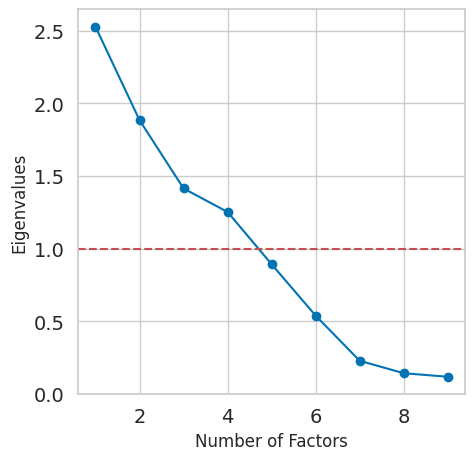

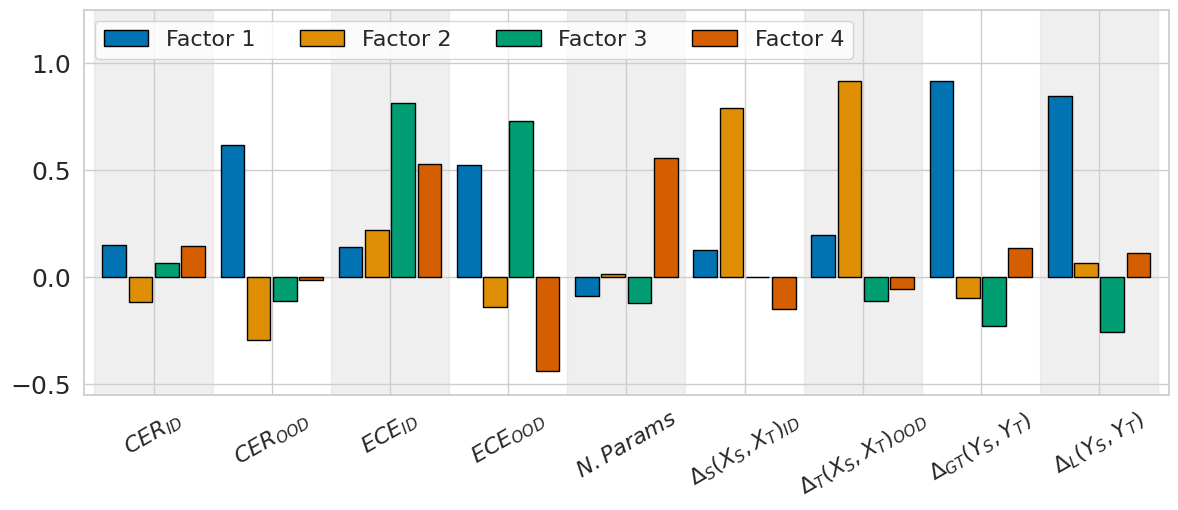

In [21]:
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

# Scale the data to [-1, 1]
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pd_all_melted_fa = scaler.fit_transform(pd_all_melted_fa)

# Make a plot for each type of rotation
plt.figure(figsize=(20, 10))

N_FACTORS = 4
rotation_idx = 1
rotations = ['varimax', 'oblimax', 'quartimax', 'equamax', 'geomin_ort', 'promax', 'oblimin', 'quartimin', 'geomin_obl']
rotation = rotations[rotation_idx]
print(f'Rotation: {rotation}')
fa = FactorAnalyzer(n_factors=N_FACTORS, rotation=rotation)
fa.fit(pd_all_melted_fa)

# Get correlation matrix
correlation_matrix = fa.corr_
print(f'Correlation matrix:')
# Convert to dataframe and display
display(pd.DataFrame(correlation_matrix, columns=columns, index=columns))

# Get the standarized factor loadings
loadings = fa.loadings_
print(loadings)

# Get the variance explained
variance_explained = fa.get_factor_variance()
print(f'Cumulative variance explained: {variance_explained[2]}')

# Get the communalities
communalities = fa.get_communalities()
print(f'Communalities: {communalities}')


# Get eigenvalues
eigenvalues = fa.get_eigenvalues()
print(f'eigenvalues: {eigenvalues}')


# Plot eigenvalues and variance explained
plt.figure(figsize=(5, 5))
plt.plot(range(1, pd_all_melted_fa.shape[1] + 1), eigenvalues[0], marker='o')
plt.xlabel('Number of Factors')
plt.axhline(y=1, color='r', linestyle='--') # Horiziontal line in
plt.ylabel('Eigenvalues')
# make the xticks bigger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title('Scree Plot')
# Save as pdf
plt.savefig('../results/scree_plot.pdf', format='pdf', bbox_inches='tight')

# Make a plot in which each x is a column of data and each barplot represents the contribution of each factor (3 factors)
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
x = np.arange(pd_all_melted_fa.shape[1])
y = loadings.T

# Get matrix with p-values in the correlation matrix using scipy
from scipy import stats
p_values = np.zeros((pd_all_melted_fa.shape[1], pd_all_melted_fa.shape[1]))
for i in range(pd_all_melted_fa.shape[1]):
    for j in range(pd_all_melted_fa.shape[1]):
        p_values[i, j] = stats.pearsonr(pd_all_melted_fa[:, i], pd_all_melted_fa[:, j])[1]
        
print(f'P-values: \n')
# Make a dataframe with the p-values and set bottom triangle to 0
p_values = pd.DataFrame(p_values, columns=columns, index=columns)
p_values = p_values.where(np.triu(np.ones(p_values.shape)).astype(np.bool))
display(p_values)

# Make a dataframe with each metric and the correlation with the factors
pd_loadings = pd.DataFrame(loadings.T, columns=columns, index=[f'Factor {i + 1}' for i in range(N_FACTORS)])
display(pd_loadings)

# Add background color alternating each xtick
for i in range(0, len(columns), 2):
    ax.axvspan(i - 0.5, i + 0.5, color='lightgrey', alpha=0.35)

# Change palette to colorblind
sns.set_palette('colorblind')

# Change paletete matplotlib to colorblind
# colors = plt.cm.get_cmap('tab10', N_FACTORS).colors

# Make the correct space for 3 bars, set the xtick in the middle of the 3 bars
positions_bars = np.linspace(-1/(N_FACTORS-1), 1/(N_FACTORS-1), N_FACTORS)
for i in range(N_FACTORS):
  # Set the position in the middle of the 3 bars
  position = x + positions_bars[i]
  ax.bar(position, y[i], width=1/(N_FACTORS+1), label=f'Factor {i + 1}', edgecolor='black')
    
# Remove padding inside the plot at the left and right
plt.margins(x=0.01)
# plt.xticks(x, columns)

columns = ['$CER_{ID}$', '$CER_{OOD}$', '$ECE_{ID}$', '$ECE_{OOD}$', '$N. Params$', '$\Delta_S(X_S, X_T)_{ID}$', '$\Delta_T(X_S, X_T)_{OOD}$', '$\Delta_{GT}(Y_S, Y_T)$', '$\Delta_{L}(Y_S, Y_T)$']

ax.set_xticks(x)
ax.set_xticklabels(columns, fontsize=18)



ax.legend()
# Change n columns legend ticks
ax.legend(loc='upper left', ncol=4, fontsize=16)
plt.xticks(rotation=30, fontsize=16)
plt.grid(True, axis='y')
plt.ylim(-0.55, 1.25)

# Put the values of the loadings in the plot
# for i in range(N_FACTORS):
#   ax.bar_label(ax.containers[i], labels=[f'{str(np.round(val, 2)).replace("0", "")}' if abs(np.round(val, 2)) >= 0.3 and abs(val) <= 1.0 else '' for val in y[i]], label_type='edge', fontsize=10)

plt.yticks([-.5, 0.0, 0.5, 1.0], size=18)

# Save as pdf
plt.savefig('../results/factor_analysis.pdf', format='pdf', bbox_inches='tight')
  

Index(['CER_ID', 'CER_OOD', 'calibration_ID', 'calibration_OOD',
       'num_parameters', 'reconstruction_error_ID', 'reconstruction_error_OOD',
       'kl_divergence_real', 'kl_divergence'],
      dtype='object')
Coefficients: [ 4.56036649e-01 -1.03331283e+01  3.94822321e-02 -1.69586985e+02
  6.30357851e+01  1.02371346e+01]
Intercept: 27.034170383979664
R2 score: 0.4182873910458569
Mean absolute error: 11.064497600330903. Std error: 7.966603008847458
Mean residuals: 11.064497600330903
Std residuals: 7.966603008847458
Max residuals: 38.555394937933755
Min residuals: 0.003781262505782479
Median residuals: 9.575333911332834


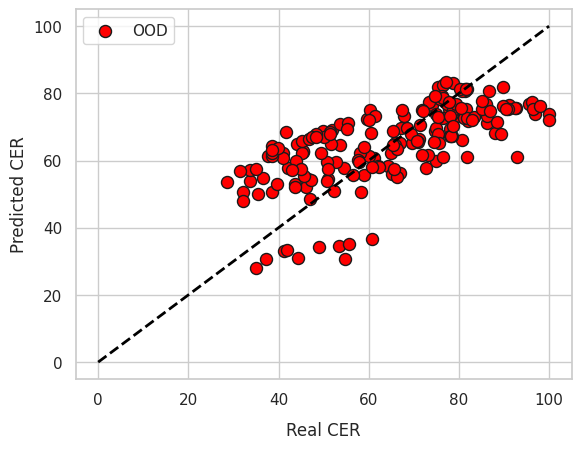

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
pd_all_pred = pd_all_melted.drop(columns=['Name', 'train_datasets', 'test_dataset', 'architecture'])

# X = pd_all_pred.drop(columns=['CER_OOD', 'CER_ID'])

print(pd_all_pred.columns)
# X = pd_all_pred[['CER_ID', 'calibration_ID','num_parameters', 'reconstruction_error_OOD', 'reconstruction_error_ID','kl_divergence', 'kl_divergence_real']]
X = pd_all_pred[['CER_ID', 'calibration_ID','num_parameters', 'reconstruction_error_OOD', 'reconstruction_error_ID','kl_divergence_real']]
# X = pd_all_pred[['CER_ID', 'calibration_ID', 'num_parameters', 'reconstruction_error_OOD', 'reconstruction_error_ID', 'kl_divergence']]
# X = pd_all_pred[['CER_ID', 'calibration_ID', 'num_parameters', 'reconstruction_error_OOD', 'reconstruction_error_ID', 'kl_divergence']]
# X = pd_all_pred[['kl_divergence']]
# X = pd_all_pred[['kl_divergence_real']]
# Logaritmic fit
# X = np.log(X)
y = pd_all_pred['CER_OOD'] 


lm = LinearRegression()
# Normalize the data
lm.fit(X, y)

# Get coefficients
coefficients = lm.coef_
intercept = lm.intercept_
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

# Get R2 score
r2_score = lm.score(X, y)
print(f'R2 score: {r2_score}')


# Get the predicted values
y_pred = lm.predict(X)

# Get the residuals
residuals = np.abs(y - y_pred)

# Get the mean error of the residuals
mean_error = np.mean(residuals)
std_error = np.std(residuals)
print(f'Mean absolute error: {mean_error}. Std error: {std_error}')

# Change color to ID and OOD. ID is blue and OOD is red. Criterion is if CER_ID == CER_OOD
colors = pd_all_pred.apply(lambda x: 'blue' if x['CER_ID'] == x['CER_OOD'] else 'red', axis=1)


# Plot real CER vs predicted CER. Add markersize=10 and edgecolors='k'. Set two labels: ID and OOD with different colors
idx_id = pd_all_pred['CER_ID'] == pd_all_pred['CER_OOD']
idx_ood = ~idx_id

# Remove outliers for the plot with quartiles
outliers = (residuals > np.percentile(residuals, 75) + 1.5 * (np.percentile(residuals, 75) - np.percentile(residuals, 25))) | (residuals < np.percentile(residuals, 25) - 1.5 * (np.percentile(residuals, 75) - np.percentile(residuals, 25)))
idx_id = idx_id & ~outliers
idx_ood = idx_ood & ~outliers

plt.scatter(y[idx_id], y_pred[idx_id], c='blue', label='ID', edgecolors='k', s=75) if len(y[idx_id]) > 0 else None
plt.scatter(y[idx_ood], y_pred[idx_ood], c='red', label='OOD', edgecolors='k', s=75) 

# plt.scatter(y[idx_id], y_pred[idx_id], c='blue', label='ID', edgecolors='k', s=70)
# plt.scatter(y[idx_ood], y_pred[idx_ood], c='red', label='OOD', edgecolors='k', s=70)

# Get all statistics about residuals distribution: mean, std, max, min, median, etc
print(f'Mean residuals: {np.mean(residuals)}')
print(f'Std residuals: {np.std(residuals)}')
print(f'Max residuals: {np.max(residuals)}')
print(f'Min residuals: {np.min(residuals)}')
print(f'Median residuals: {np.median(residuals)}')



plt.xlabel('Real CER', fontsize=12, labelpad=10)
plt.ylabel('Predicted CER', fontsize=12)
plt.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=2)

# Make numbers of the axis bigger
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.xlim(0, 100)
# plt.ylim(0, 100)

# Set legend
plt.legend()

# Save as pdf
plt.savefig('../results/cer_vs_predicted_cer.pdf', format='pdf', bbox_inches='tight')



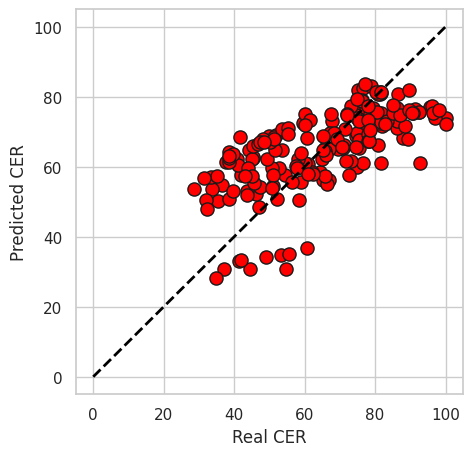

In [23]:
# Plot the real CER vs a line with the linear regression model
plt.figure(figsize=(5, 5))
plt.scatter(y[idx_ood], y_pred[idx_ood], c='red', label='OOD', edgecolors='k', s=90)
plt.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=2)
plt.xlabel('Real CER', fontsize=12)
plt.ylabel('Predicted CER', fontsize=12)

# Save as pdf
plt.savefig('../results/cer_vs_predicted_cer_ood.pdf', format='pdf', bbox_inches='tight')


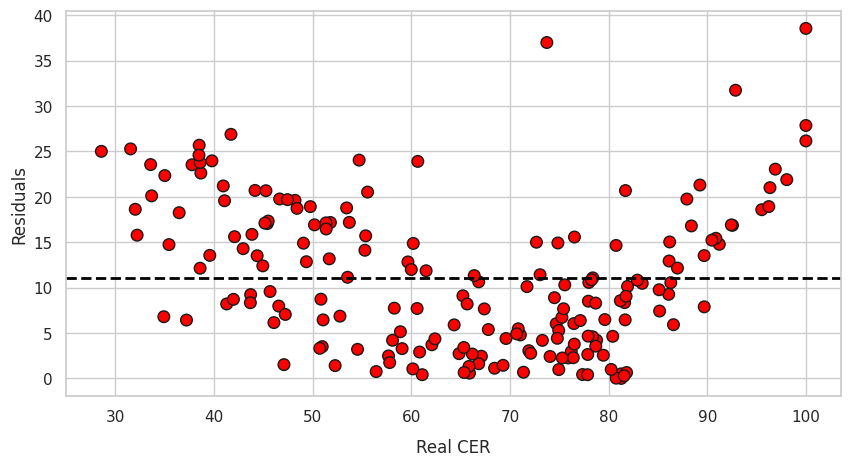

In [24]:
# Plot CER vs residuals. Add markersize=10 and edgecolors='k'. Set two labels: ID and OOD with different colors
plt.figure(figsize=(10, 5))
plt.scatter(y, residuals, c=colors, edgecolors='k', s=70)
plt.xlabel('Real CER', fontsize=12, labelpad=10)
plt.ylabel('Residuals', fontsize=12)
plt.axhline(y=mean_error, color='black', linestyle='--', linewidth=2)
# plt.axhline(y=mean_error + std_error, color='black', linestyle='--', linewidth=2)
# plt.axhline(y=mean_error - std_error, color='black', linestyle='--', linewidth=2)


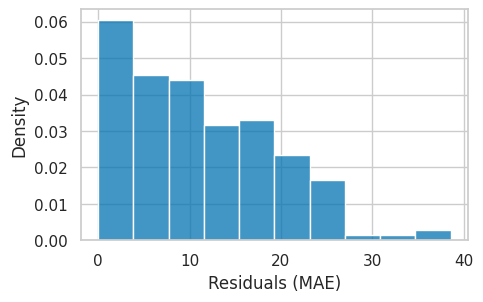

In [25]:
# Plot residuals distribution with seaborn where frequency is in percentage. Set bins of 10
plt.figure(figsize=(5, 3))
sns.histplot(residuals, kde=False, bins=10, stat='density')
plt.xlabel('Residuals (MAE)', fontsize=12)
plt.ylabel('Density', fontsize=12)
# plt.title('Residuals distribution')
plt.grid(True)



Text(18.911381379011658, 50, '16.91')

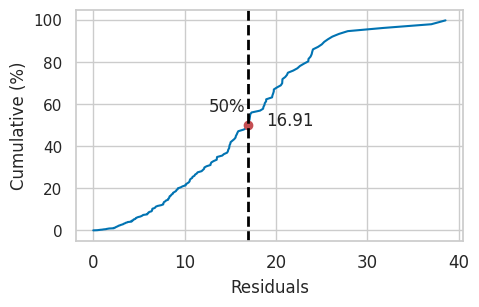

In [26]:
# Get the cumulative percentaje of residuals 
cumulative_percentaje = np.cumsum(np.sort(residuals)) / np.sum(residuals) * 100
plt.figure(figsize=(5, 3))
plt.plot(np.sort(residuals), cumulative_percentaje)
plt.xlabel('Residuals', fontsize=12, labelpad=5)
plt.xticks(np.arange(0, 50, 10), fontsize=12)
plt.ylabel('Cumulative (%)', fontsize=12)

# Mark with a point the 75% of the residuals and set the label
perc = 50
plt.plot(np.sort(residuals)[np.where(cumulative_percentaje >= perc)[0][0]], perc, 'ro')
plt.annotate(f'{perc}%', (np.sort(residuals)[np.where(cumulative_percentaje >= perc)[0][0]], perc), textcoords='offset points', xytext=(-15, 10), ha='center', fontsize=12)
# Mark the residuals with perc% of the residuals
plt.axvline(x=np.sort(residuals)[np.where(cumulative_percentaje >= perc)[0][0]], color='black', linestyle='--', linewidth=2)
plt.text(np.sort(residuals)[np.where(cumulative_percentaje >= perc)[0][0]] + 2.0, perc, f'{np.round(np.sort(residuals)[np.where(cumulative_percentaje >= perc)[0][0]], 2)}', fontsize=12)


In [27]:
# Count values where predicted CER is greater than real CER and viceversa, give the percentage
print(f'Count where predicted CER is greater than real CER: {np.sum(y_pred > y)}')
print(f'Count where predicted CER is less than real CER: {np.sum(y_pred < y)}')
print(f'Percentage where predicted CER is greater than real CER: {np.sum(y_pred > y) / len(y) * 100}')
print(f'Percentage where predicted CER is less than real CER: {np.sum(y_pred < y) / len(y) * 100}')


Count where predicted CER is greater than real CER: 85
Count where predicted CER is less than real CER: 104
Percentage where predicted CER is greater than real CER: 44.97354497354497
Percentage where predicted CER is less than real CER: 55.026455026455025


In [28]:
# Get the cases with the largest 10 residuals in original tables to see architecture, train_datasets, test_dataset, CER_ID, CER_OOD, calibration_ID, calibration_OOD
largest_residuals_idx = np.argsort(residuals)[-10:]
print(f'Cases with the largest residuals: \n')

print(f'Len residuals: {len(residuals)}. len pd_all_melted: {len(pd_all_melted)}')

cases = pd_all_melted.iloc[largest_residuals_idx].copy()
# Add residuals to the table
# cases['residuals'] = residuals[largest_residuals_idx]
display(cases)

Cases with the largest residuals: 

Len residuals: 189. len pd_all_melted: 189


Name train_datasets architecture  \
286         van_coquenet_src_iam_ID_test            iam          VAN   
252       van_coquenet_src_rimes_ID_test          rimes          VAN   
258       cnn_san_arce_src_rimes_ID_test          rimes        C-SAN   
106              htr_vit_src_iam_ID_test            iam      HTR-VIT   
221  van_coquenet_src_washington_ID_test     washington          VAN   
182     van_coquenet_src_bentham_ID_test        bentham          VAN   
251     crnn_puig_src_washington_ID_test     washington         CRNN   
208     crnn_michael_src_rodrigo_ID_test        rodrigo      Michael   
216  van_coquenet_src_washington_ID_test     washington          VAN   
204     crnn_michael_src_rodrigo_ID_test        rodrigo      Michael   

    test_dataset     CER_ID     CER_OOD  calibration_ID  calibration_OOD  \
286      rodrigo   6.606574   38.469115        0.347782         0.403743   
252          iam   5.639034   28.571898        0.446951         0.546822   
258          iam  11.972670   31.535220        0.409742         0.497092   
106      rodrigo  10.863325   38.489693        0.622314         0.541639   
221   icfhr_2016   9.314642  100.000000        0.545254         0.894201   
182        rimes   7.400153   41.712973        0.381724         0.560703   
251   icfhr_2016   8.208723  100.000000        0.687055         0.916094   
208   saint_gall   3.805534   92.865843        0.119315         0.455822   
216          iam   9.314642   73.734456        0.545254         0.819675   
204          iam   3.805534  100.000000        0.119315         0.479612   

     num_parameters  reconstruction_error_ID  reconstruction_error_OOD  \
286             2.7                 0.026565                  0.047759   
252             2.7                 0.048819                  0.062380   
258             1.7                 0.048819                  0.062380   
106            53.5                 0.026565                  0.047759   
221             2.7                 0.033277                  0.057726   
182             2.7                 0.014059                  0.024930   
251             9.6                 0.033277                  0.057726   
208             8.0                 0.032326                  0.039081   
216             2.7                 0.033277                  0.048566   
204             8.0                 0.032326                  0.034388   

     kl_divergence_real  kl_divergence  
286               4.194          2.368  
252               3.516          2.636  
258               3.516          2.636  
106               4.194          2.368  
221               5.448          3.040  
182               4.432          2.368  
251               5.448          3.040  
208               3.698          2.552  
216               1.672          1.390  
204               3.652          2.584

In [29]:
# Plot kl divergence vs CER OOD
plt.figure(figsize=(10, 5))
plt.scatter(pd_all_melted_fa['KL div.'], residuals, c='blue', edgecolors='k', s=70)
plt.xlabel('KL divergence', fontsize=12, labelpad=10)
plt.ylabel('Residuals', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 1000x500 with 0 Axes>

[  0  20  40  60  80 100]
[3 4 4 5 2 3 3 5 4 4 4 4 4 4 5 4 3 3 3 5 4 5 3 4 4 5 4 4 4 4 4 4 4 2 4 3 2
 3 3 3 4 3 3 5 3 4 5 4 5 4 4 4 4 2 3 3 5 3 2 5 4 5 4 5 4 4 4 2 4 4 4 4 4 4
 4 5 4 5 5 5 4 5 5 5 4 5 4 3 4 2 3 4 2 3 4 2 3 2 2 3 3 2 4 5 5 5 5 4 4 3 3
 3 4 3 5 3 6 5 4 4 4 4 4 6 2 2 3 3 3 4 4 4 4 4 5 3 3 3 4 3 5 3 4 4 4 6 2 3
 3 5 2 3 3 5 3 3 3 4 4 5 3 2 3 4 3 5 2 2 5 3 3 5 3 4 3 5 3 4 5 3 3 5 3 4 3
 5 3 3 5]
[nan, 19.30894087703248, 12.449506299121062, 6.271116622452779, 12.078408140440292]


<Axes: >

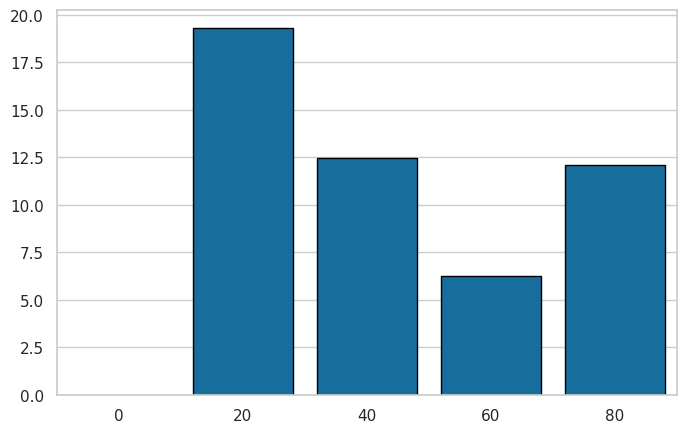

In [ ]:
# TODO: HACER POR RANGOS
# Make a plot with bins for real CER vs residuals obtained in residuals


# Organize the data in bins only positive CER values. For real CER values in the range [0, 100] with a step of 10
bins = np.arange(0, 120, 20)
print(bins)

# Get the indexes of the bins
indexes = np.digitize(y, bins)
print(indexes)

# Get the mean residuals for each bin
mean_residuals = [np.mean(residuals[indexes == i]) for i in range(1, len(bins))]
print(mean_residuals)

# Get the std residuals for each bin
std_residuals = [np.std(residuals[indexes == i]) for i in range(1, len(bins))]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.barplot(x=bins[:-1], y=mean_residuals, ax=ax, edgecolor='black', capsize=2)

[ 0  5 10 15 20 25 30 35 40]
[29.100529100529098, 21.693121693121693, 17.46031746031746, 16.93121693121693, 10.052910052910052, 3.1746031746031744, 0.5291005291005291, 1.0582010582010581]
29.1
29.1, 31.100529100529098
21.7
50.8, 23.693121693121693
17.5
68.3, 19.46031746031746
16.9
85.2, 18.93121693121693
10.1
95.2, 12.052910052910052
3.2
98.4, 5.174603174603174
0.5
98.9, 2.5291005291005293
1.1
100.0, 3.058201058201058


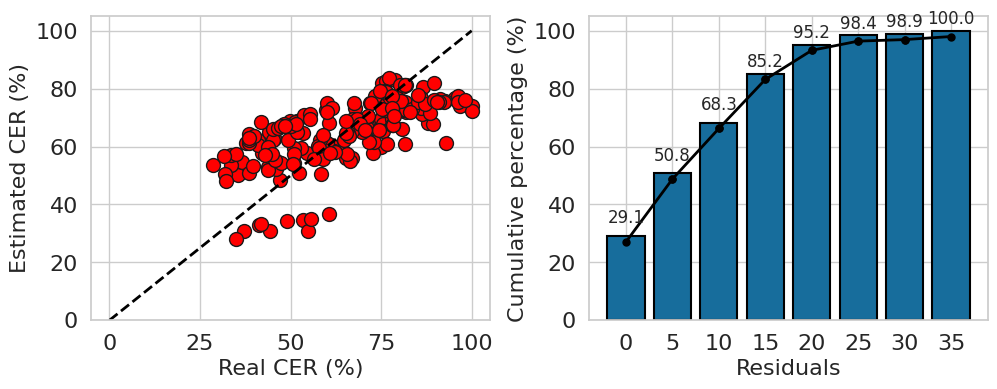

In [ ]:
# Plot real CER vs residuals

# Plot two subplots CER vs. residuals and residuals distribution in ascending order

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(y[idx_ood], y_pred[idx_ood], c='red', label='OOD', edgecolors='k', s=100)
ax[0].plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=2)
ax[0].set_xlabel('Real CER (%)', fontsize=16)
ax[0].set_ylabel('Estimated CER (%)', fontsize=16)

ax[0].set_ylim(0, 105)


# Make the same plot but with residuals in bins of 5 and show the percentage of residuals in each bin
bins = np.arange(0, 45, 5)
print(bins)
indexes = np.digitize(residuals, bins)
perc_residuals = [np.sum(indexes == i) / len(residuals) * 100 for i in range(1, len(bins))]
# perc_residuals = np.cumsum(perc_residuals)
cum_perc_residuals = np.cumsum(perc_residuals)
print(perc_residuals)

sns.barplot(x=bins[:-1], y=cum_perc_residuals, ax=ax[1], edgecolor='black', capsize=10, linewidth=1.5)
# ax[1].barplot(x=bins[:-1], y=perc_residuals, ax=ax, edgecolor='black', capsize=2)
ax[1].set_xlabel('Residuals', fontsize=16)
ax[1].set_ylabel('Cumulative percentage (%)', fontsize=16)
# plt.xticks(fontsize=11)
# Change xticks to set as ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35']
# plt.xticks(np.arange(0, 40, 5), [f'{i}-{i + 5}' for i in range(0, 40, 5)], fontsize=11)

# ax[1].yticks(fontsize=12)
ax[1].grid(True)
ax[1].set_ylim(0, 105)
# ax[1].set_ylim(0, 34)

# Above each bin the percentage of residuals and the accumulated percentage
for i, perc in enumerate(perc_residuals):
    # plt.text(i, perc + 0.5 , f'{perc:.2f}', ha='center', va='bottom', fontsize=10)
    print(f'{perc:.1f}')
    # perc = cum_perc_residuals[i]
    perc = cum_perc_residuals[i]
    location = perc_residuals[i] + 2
    print(f'{perc:.1f}, {location}')
    # perc, location = location, perc
    ax[1].text(i, perc + 1.0 if perc > 80. else perc + 3.0 , f'{perc:.1f}', ha='center', va='bottom', fontsize=12)
    # ax[1].text(i, perc, f'{perc:.1f}', ha='center', va='bottom', fontsize=12)
    
# Draw a line joining the points mantaining the order and scale manually
for i in range(len(perc_residuals) - 1):
    # ax[1].plot([i, i + 1], [perc_residuals[i] - 1.0, perc_residuals[i + 1] - 1.0], color='black', linestyle='-', linewidth=2, marker='o', markersize=5)
    # Add the cumulative perc
    ax[1].plot([i, i + 1], [cum_perc_residuals[i] - 2.0, cum_perc_residuals[i + 1] - 2.0], color='black', linestyle='-', linewidth=2, marker='o', markersize=5)

# add space between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

# Set all ticks to 12
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)



# Save as pdf
plt.savefig('../results/residuals_distribution.pdf', format='pdf', bbox_inches='tight')

In [ ]:
pd_all_melted_fa

ID Error  OOD Error    ID ECE   OOD ECE  N. Params  Rec. error (ID)  \
0    8.167952  54.545456  0.175784  0.209804        8.0         0.048819   
3    8.167952  64.339137  0.175784  0.328618        8.0         0.048819   
4    8.167952  66.828722  0.175784  0.306774        8.0         0.048819   
5    8.167952  86.304390  0.175784  0.528438        8.0         0.048819   
6    3.742345  35.427809  0.720046  0.766574        9.6         0.048819   
..        ...        ...       ...       ...        ...              ...   
328  4.969948  56.434792  0.082715  0.438988        7.7         0.048819   
329  4.969948  90.473449  0.082715  0.787336        7.7         0.048819   
333  8.877662  51.362967  0.072671  0.459570        7.7         0.026565   
334  8.877662  48.408481  0.072671  0.430202        7.7         0.026565   
335  8.877662  98.059231  0.072671  0.854684        7.7         0.026565   

     Rec. error (OOD)  KL div. (GT)  KL div.  
0            0.062380         3.516    2.636  
3            0.095761         4.136    2.788  
4            0.101431         4.010    2.608  
5            0.080102         5.568    3.134  
6            0.062380         3.516    2.636  
..                ...           ...      ...  
328          0.101431         4.010    2.608  
329          0.080102         5.568    3.134  
333          0.046390         4.238    2.408  
334          0.047759         4.194    2.368  
335          0.027919         4.746    2.332  

[189 rows x 9 columns]

In [ ]:
# # Plot CER in OOD with respect KL Divergence
# plt.figure(figsize=(8, 5))

# # Make a scatter plot with CER in OOD vs KL Divergence. Color the points according to the reconstruction error
# print(pd_all_melted_fa['KL div.'])
# plt.scatter(pd_all_melted_fa['KL div.'], pd_all_melted_fa['OOD Error'], cmap='viridis', edgecolors='k', s=70)

Coefficients: [12.93347819]
Intercept: 31.106164683612974
R2 score: 0.27254917184674377
Mean error: 11.981060826338062. Std error: 9.429507071186245


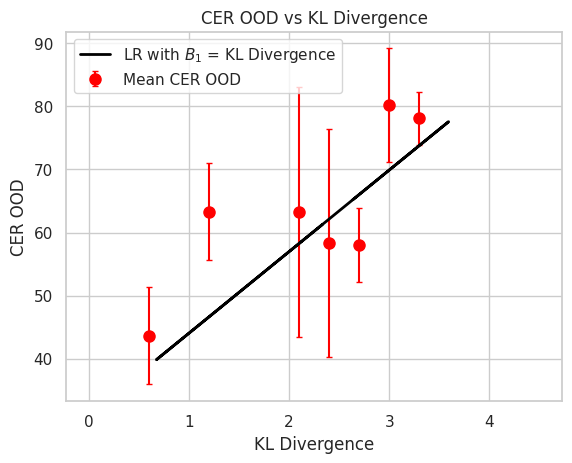

In [ ]:
# Make it in bins of 0.5 for KL Divergence and plot the mean CER in OOD for each bin
bins = np.arange(0, 5, 0.3)

# Get the indexes of the bins
indexes = np.digitize(pd_all_melted_fa['KL div.'], bins)

# Get the mean residuals for each bin
mean_cer = [np.mean(pd_all_melted_fa['OOD Error'][indexes == i]) for i in range(1, len(bins))]
std_cer = [np.std(pd_all_melted_fa['OOD Error'][indexes == i]) for i in range(1, len(bins))]

plt.errorbar(bins[:-1], mean_cer, fmt='o', color='red', capsize=2, label='Mean CER OOD', markersize=8, yerr=std_cer)

# Also plot the residuals in the same plot
# residuals = pd_all_melted_fa['CER_OOD'] - y_pred
# plt.scatter(pd_all_melted_fa['kl_divergence'], residuals, cmap='viridis', edgecolors='k', s=70)

plt.xlabel('KL Divergence')
plt.ylabel('CER OOD')
plt.title('CER OOD vs KL Divergence')
plt.legend()

# Make a linear regression to adjust CER OOD with respect to KL Divergence
lm = LinearRegression()
X = pd_all_melted_fa[['KL div.']]
y = pd_all_melted_fa['OOD Error']
lm.fit(X, y)

# Get coefficients
coefficients = lm.coef_
intercept = lm.intercept_
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

# Get R2 score
r2_score = lm.score(X, y)
print(f'R2 score: {r2_score}')

# Get the predicted values
y_pred = lm.predict(X)

# Calculate MAE
residuals = np.abs(y - y_pred)
mean_error = np.mean(residuals)
std_error = np.std(residuals)
print(f'Mean error: {mean_error}. Std error: {std_error}')

# Make a plot with the linear regression
plt.plot(X, y_pred, color='black', linewidth=2, label='LR with $B_1$ = KL Divergence')
plt.legend()




<ErrorbarContainer object of 3 artists>

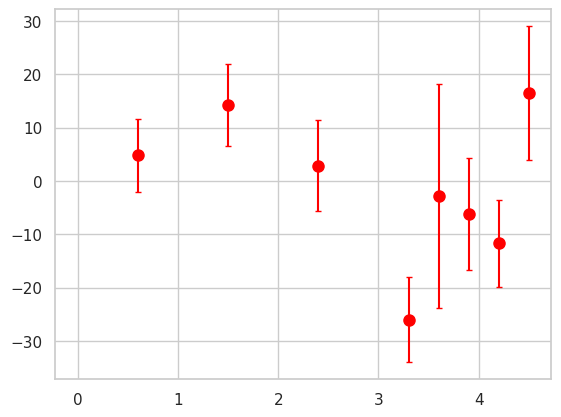

In [ ]:
# Get also the residuals with kl binning

bins = np.arange(0, 5, 0.3)

# Get the indexes of the bins
indexes = np.digitize(pd_all_melted_fa['KL div. (GT)'], bins)

differences = pd_all_melted_fa['OOD Error'] - y_pred

mean_residuals = [np.mean(differences[indexes == i]) for i in range(1, len(bins))]
std_residuals = [np.std(differences[indexes == i]) for i in range(1, len(bins))]

plt.errorbar(bins[:-1], mean_residuals, fmt='o', color='red', capsize=2, label='Mean residuals', markersize=8, yerr=std_residuals)
                 

                 


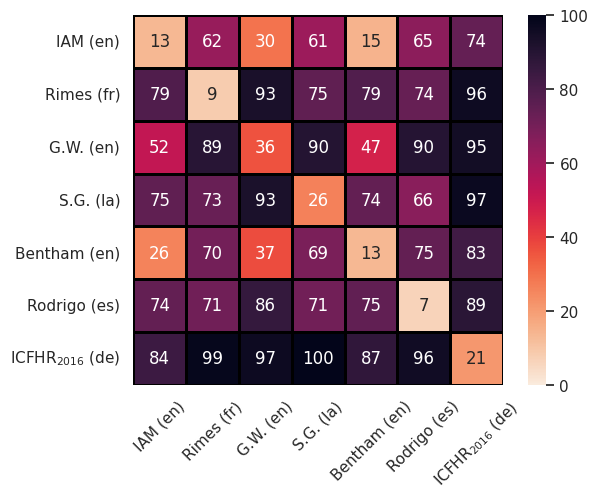

In [30]:
# Create a heatmap reading ../results/kl_divergence_real.csv
#lexical_divergences_real_dict

sns.set(style="whitegrid")

# Initialize the figure
# plt.figure(figsize=(7, 5))

# Adjust the space between subplots
# plt.subplots_adjust(hspace=5.)

# Plot the scatter plots with Seaborn's color palette
# Choose the palette with 6 different colors that can be easily distinguished
palette = sns.color_palette("rocket", as_cmap=True)

# Change the palette to colorblind
sns.set_palette('colorblind')

# Change labels: iam: 'IAM', washington: 'G.W.', bentham: 'Bentham', rimes: 'Rimes', saint_gall: 'S.G.', rodrigo: 'Rodrigo', icfhr_2016: 'ICFHR 2016'
# labels = dict({'iam': 'IAM', 'rimes': 'Rimes', 'washington': 'G.W.', 'saint_gall': 'S.G.', 'bentham': 'Bentham', 'rodrigo': 'Rodrigo ', 'icfhr_2016': 'ICFHR 2016'})
labels = dict({'iam': 'IAM (en)', 'rimes': 'Rimes (fr)', 'washington': 'G.W. (en)', 'saint_gall': 'S.G. (la)', 'bentham': 'Bentham (en)', 'rodrigo': 'Rodrigo (es)', 'icfhr_2016': 'ICFHR$_{2016}$ (de)'})

max_value = np.max(lexical_divergences_real.values.flatten()).astype(np.float64)

# Reverse palette
palette = sns.color_palette("rocket_r", as_cmap=True)

# Normalize the data and add rotation to the xticks 
plot = sns.heatmap(lexical_divergences_real / max_value * 100, annot=True, fmt=".0f", xticklabels=labels.values(), yticklabels=labels.values(), vmin=0, vmax=100, square=True, label='Real KL Divergence', linewidths=1, linecolor='black', cmap=palette)
            # xticklabels=True, yticklabels=True, vmin=0, vmax=1, cbar_kws={'label': 'KL Divergence'}, square=True)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

# Save as pdf
plt.savefig('../results/heatmap_kl_divergence_real.pdf', format='pdf', bbox_inches='tight')



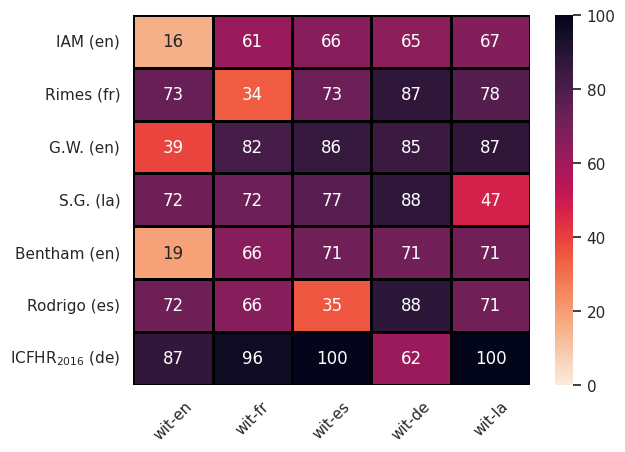

In [31]:
# Create a heatmap reading ../results/kl_divergence_wit_ALL.csv
#lexical_divergences

sns.set(style="whitegrid")

# Choose the palette with 6 different colors that can be easily distinguished
palette = sns.color_palette("rocket", as_cmap=True)

# Change the palette to colorblind
# sns.set_palette('colorblind')

# Change labels: iam: 'IAM', washington: 'G.W.', bentham: 'Bentham', rimes: 'Rimes', saint_gall: 'S.G.', rodrigo: 'Rodrigo', icfhr_2016: 'ICFHR 2016'
# labels = dict({'iam': 'IAM', 'rimes': 'Rimes', 'washington': 'G.W.', 'saint_gall': 'S.G.', 'bentham': 'Bentham', 'rodrigo': 'Rodrigo', 'icfhr_2016': 'ICFHR 2016'})
labels = dict({'iam': 'IAM (en)', 'rimes': 'Rimes (fr)', 'washington': 'G.W. (en)', 'saint_gall': 'S.G. (la)', 'bentham': 'Bentham (en)', 'rodrigo': 'Rodrigo (es)', 'icfhr_2016': 'ICFHR$_{2016}$ (de)'})
labels_wit = dict({'wit-en': 'wit-en', 'wit-fr': 'wit-fr', 'wit-es': 'wit-es', 'wit-de': 'wit-de', 'wit-la': 'wit-la'})

# print(lexical_divergences)
# print(np.max(lexical_divergences))
max_value = np.max(lexical_divergences.values.flatten()).astype(np.float64)

# Reverse palette
palette = sns.color_palette("rocket_r", as_cmap=True)

# Normalize the data and add rotation to the xticks = 45 to rotate the labels
plot = sns.heatmap(lexical_divergences / max_value * 100, annot=True, fmt=".0f", xticklabels=labels_wit.values(), yticklabels=labels.values(), vmin=0, vmax=100, square=False, linewidths=1, linecolor='black', cmap=palette)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


            # xticklabels=True, yticklabels=True, vmin=0, vmax=1, cbar_kws={'label': 'KL Divergence'}, square=True)ww

# Save as pdf
plt.savefig('../results/heatmap_kl_divergence_synth.pdf', format='pdf', bbox_inches='tight')



0.1014307395954748


0.1014307395954748


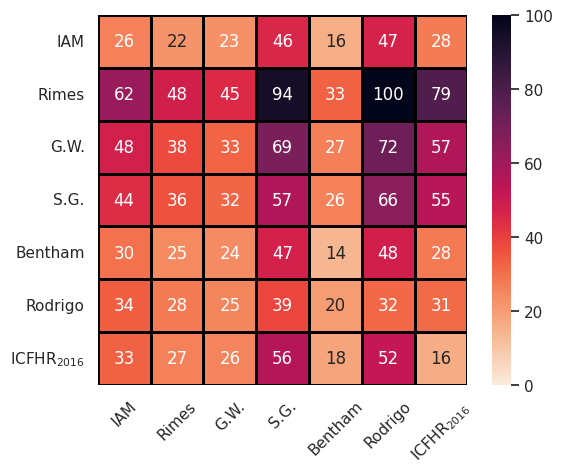

In [32]:
# Heatmap for the visual differences reconstruction errors
sns.set(style="whitegrid")

palette = sns.color_palette("rocket", as_cmap=True)

# Change the palette to colorblind
sns.set_palette('colorblind')

# Change labels: iam: 'IAM', washington: 'G.W.', bentham: 'Bentham', rimes: 'Rimes', saint_gall: 'S.G.', rodrigo: 'Rodrigo', icfhr_2016: 'ICFHR 2016'
labels = dict({'iam': 'IAM', 'rimes': 'Rimes', 'washington': 'G.W.', 'saint_gall': 'S.G.', 'bentham': 'Bentham', 'rodrigo': 'Rodrigo', 'icfhr_2016': 'ICFHR$_{2016}$'})

show(reconstruction_errors)
print(np.max(reconstruction_errors.values.flatten()))



reconstruction_errors_copy = reconstruction_errors.copy()

# if for a source target the reconstruction error is > in the target than in the source, make a swap
# for i in range(reconstruction_errors_copy.shape[0]):
#     for j in range(reconstruction_errors_copy.shape[1]):
#         if reconstruction_errors_copy.iloc[i, j] > reconstruction_errors_copy.iloc[j, i]:
#             reconstruction_errors_copy.iloc[i, j], reconstruction_errors_copy.iloc[j, i] = reconstruction_errors_copy.iloc[j, i], reconstruction_errors_copy.iloc[i, j]
            
show(reconstruction_errors)
show(reconstruction_errors_copy)

# Sum 20% points to the reconstruction errors where source is Rimes. Only for that source!
# reconstruction_errors_copy[reconstruction_errors_copy.index == 'rimes'] = reconstruction_errors_copy[reconstruction_errors_copy.index == 'rimes'] * 1.2 

# Get the max value for all the reconstruction errors
max_value = np.max(reconstruction_errors_copy.values.flatten()).astype(np.float64)
print(max_value)


# Reverse palette
palette = sns.color_palette("rocket_r", as_cmap=True)

# Normalize the data and add rotation to the xticks
# plot = sns.heatmap(reconstruction_errors_copy, annot=True, fmt=".0f", xticklabels=labels.values(), yticklabels=labels.values(), vmin=0, vmax=100, square=False, linewidths=1, linecolor='black')
# plot = sns.heatmap(100 - reconstruction_errors_copy / max_value * 100, annot=True, fmt=".0f", xticklabels=labels.values(), yticklabels=labels.values(), vmin=0, vmax=100, square=False, linewidths=1, linecolor='black')
plot = sns.heatmap(reconstruction_errors / max_value * 100, annot=True, fmt=".0f", xticklabels=labels.values(), yticklabels=labels.values(), vmin=0, vmax=100, square=True, linewidths=1, linecolor='black', cmap=palette)

plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

# Save as pdf
plt.savefig('../results/heatmap_reconstruction_errors.pdf', format='pdf', bbox_inches='tight')


In [33]:
# Plot each ID results vs. KL_div for each test dataset

# Make a plot with the real KL divergence and the CER in ID

res_id = pd_all_melted_fa['ID Error']
kl_div = pd_all_melted_fa['KL div.']

# Get only the res for a single architecture
# res_id = pd_all_melted_fa[pd_all_melted_fa['architecture'] == 'CRNN']['ID Error']
# kl_div = pd_all_melted_fa[pd_all_melted_fa['architecture'] == 'CRNN']['KL div.']

# Get mean eror per bin of KL divergence
bins = np.arange(0, 5, 0.3)
indexes = np.digitize(kl_div, bins)
mean_res_id = [np.mean(res_id[indexes == i]) for i in range(1, len(bins))]
# std_res_id = [np.std(res_id[indexes == i]) for i in range(1, len(bins)]
              

# Make a scatter plot with the real KL divergence and the CER in ID
plt.figure(figsize=(10, 5))
plt.scatter(kl_div, res_id, c='blue', edgecolors='k', s=70)
# plt.scatter(bins[:-1], mean_res_id, c='blue', edgecolors='k', s=70)
plt.xlabel('KL divergence', fontsize=12)
plt.ylabel('CER ID', fontsize=12)
plt.title('CER ID vs KL divergence')
plt.grid(True)



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

0     44.615806
1     85.164487
2     52.100817
3     52.490446
4     64.569614
5     42.700545
6     89.406628
7     48.286986
8     48.281999
9     76.157784
10    77.404776
11    79.979162
12    76.398045
13    77.868200
14    80.282320
15    39.213875
16    88.864529
17    53.757486
18    56.395523
19    75.966073
20    47.060669
21    57.702876
22    63.316492
23    98.966519
24    63.029220
25    67.536348
26    68.279370
Name: CER_OOD, dtype: float64

0     0.826
1     4.924
2     4.432
3     4.220
4     4.190
5     2.670
6     4.746
7     4.194
8     4.238
9     4.688
10    4.174
11    5.420
12    5.012
13    5.484
14    5.354
15    3.516
16    5.568
17    4.010
18    4.136
19    3.652
20    3.698
21    3.994
22    1.672
23    5.448
24    5.246
25    4.854
26    5.232
Name: kl_divergence_real, dtype: float64

Coefficients: [1.3962554]
Intercept: 38.45419473858579
R2 score: -1.6649997657382127
Mean error: 21.645485699269898. Std error: 14.64779377786989


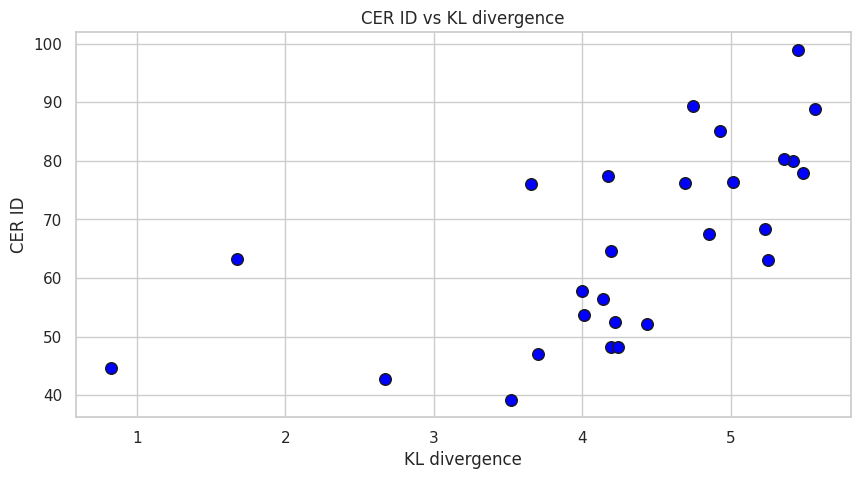

In [ ]:
pd_all_melted

# Plot each ID results vs. KL_div for each test dataset

# Make a plot with the real KL divergence and the CER in ID

# res_id = pd_all_melted['ID Error']
# kl_div = pd_all_melted['KL div.']

# Get only the res for a single architecture
res_id = pd_all_melted[pd_all_melted['architecture'] == 'CRNN']['CER_OOD']
kl_div = pd_all_melted[pd_all_melted['architecture'] == 'CRNN']['kl_divergence_real']

# Show CER results for each train and test dataset
# display(pd_all_melted[pd_all_melted['architecture'] == 'CRNN'].groupby(['train_datasets', 'test_dataset'])['CER_OOD'].mean())

# Get only one value for each train_dataset values for  CER_OOD and kl_divergence_real
res_id = pd_all_melted.groupby(['train_datasets', 'test_dataset'])['CER_OOD'].mean()
res_id = res_id.reset_index()
res_id = res_id['CER_OOD']

kl_div = pd_all_melted.groupby(['train_datasets', 'test_dataset'])['kl_divergence_real'].mean()
kl_div = kl_div.reset_index()
kl_div = kl_div['kl_divergence_real']

# Remove duplicates from res_id and get the same indexes for kl_div
res_id = res_id.drop_duplicates()
kl_div = kl_div.iloc[res_id.index]

# Train datasets
# train_datasets = pd_all_melted.iloc[res_id.index]['train_datasets']

display(res_id)
display(kl_div)
# display(train_datasets)





# res_id = pd_all_melted['CER_ID']
# kl_div = pd_all_melted['kl_divergence_real']

# # Get mean eror per bin of KL divergence
# bins = np.arange(0, 5, 0.3)
# indexes = np.digitize(kl_div, bins)
# mean_res_id = [np.mean(res_id[indexes == i]) for i in range(1, len(bins))]
# # std_res_id = [np.std(res_id[indexes == i]) for i in range(1, len(bins)]
              

# Make a scatter plot with the real KL divergence and the CER in ID
plt.figure(figsize=(10, 5))
plt.scatter(kl_div, res_id, c='blue', edgecolors='k', s=70)
# plt.scatter(bins[:-1], mean_res_id, c='blue', edgecolors='k', s=70)
plt.xlabel('KL divergence', fontsize=12)
plt.ylabel('CER ID', fontsize=12)
plt.title('CER ID vs KL divergence')
plt.grid(True)

# Adjust a linear regression model to the data
lm = LinearRegression()
X = kl_div.values.reshape(-1, 1)
y = res_id.values
lm.fit(X, y)

# Get coefficients and R2 score
coefficients = lm.coef_
intercept = lm.intercept_
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

# Get R2 score
r2_score = lm.score(X, y)
print(f'R2 score: {r2_score}')

# Get the predicted values
y_pred = lm.predict(X)

# Calculate MAE
residuals = np.abs(y - y_pred)
print(f'Mean error: {np.mean(residuals)}. Std error: {np.std(residuals)}')




